Setup

In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.optim as optim
import sqlite3
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize

# Model imports to test
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


from DataPreprocessing import DataPreprocesser
from MyDataset import MyDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
connection = sqlite3.connect('dota2.db')
cursor = connection.cursor()
MyProcesser = DataPreprocesser(connection, cursor)

Load Data

In [12]:
DataPreprocesser.to_dataframes(MyProcesser)  # Load the data into dataframes

data = MyProcesser.merge_data()

y = data.loc[:, 'radiant_win']
X = data.drop(columns=['radiant_win'])

Total number of matches available: 9837
radiant_win                                              0.546508
Radiant_Position_1_win_rate                              0.515028
Radiant_Position_1_rank                                 75.391684
Radiant_Position_1_average_kda                           9.962674
Radiant_Position_1_average_kills                        15.691176
                                                          ...    
Dire_Position_5_average_individual_match_performance     1.091149
Dire_Position_5_average_vision_participation             9.019631
Dire_Position_5_recent_win_rate                          0.515829
Dire_Position_5_recent_times_left                        0.018153
Dire_Position_5_curr_team_wl_rate                        0.498083
Length: 201, dtype: float64


View Data

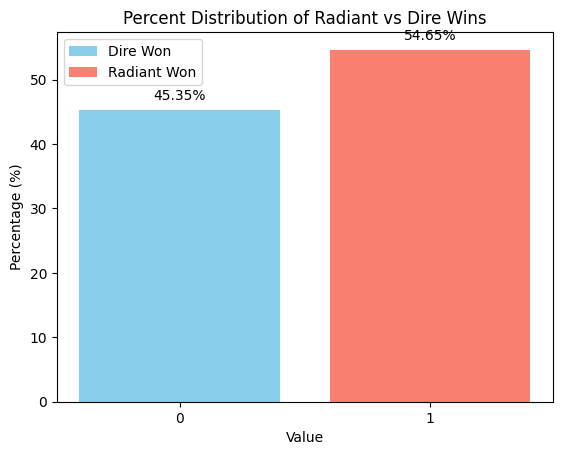

In [13]:
tmp, counts = np.unique(y, return_counts=True)
percentages = (counts / y.size) * 100

bars = plt.bar([0,1], percentages, color=['skyblue', 'salmon'])

for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Assign title and labels
plt.title('Percent Distribution of Radiant vs Dire Wins')
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
bars[0].set_label('Dire Won')
bars[1].set_label('Radiant Won')

plt.legend()
plt.xticks([0,1])  # 0 is seen as a dire win, 1 is seen as a radiant win

plt.show()

Data Setup

In [19]:
# Handle NaN values
X = X.fillna(X.mean())

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
train_data = MyDataset(X_train, y_train, transforms=None)
test_data = MyDataset(X_test, y_test, transforms=None)

In [22]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

Setting Up Models

In [23]:
# I'll be testing various models to use, and employing the best one

# For now, no parameter modifications outside of default
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB()
}

# I want to add some neural networks to be used
neural_networks = {
    "MLP": None,
}

Train Models & Neural Networks

In [24]:
for name, model in models.items():
    model.fit(X_train, y_train)  # Does the training itself
    y_pred = model.predict(X_test)
    
    # Calculate metrics below
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    
    # AUC-ROC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC Score: {roc_auc:.2f}")
    
    # Log Loss
    loss = log_loss(y_test, model.predict_proba(X_test))
    print(f"Log Loss: {loss:.2f}")
    
    # Save the model
    models[name] = model

c:\Users\ronan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 54.12%
ROC AUC Score: 0.54
Log Loss: 0.69
SVM Accuracy: 54.88%
ROC AUC Score: 0.54
Log Loss: 0.69
Decision Tree Accuracy: 52.90%
ROC AUC Score: 0.52
Log Loss: 16.98
Random Forest Accuracy: 62.25%
ROC AUC Score: 0.65
Log Loss: 0.66
Gradient Boosting Accuracy: 61.03%
ROC AUC Score: 0.65
Log Loss: 0.65
Naive Bayes Accuracy: 55.89%
ROC AUC Score: 0.57
Log Loss: 0.96


c:\Users\ronan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
for name, item in neural_networks.items():
    pass  # Requires a more complex loop, will set up later

Evaluate Models

Performance Analysis

Save Data